In [1]:
# rewire in-degrees 


In [2]:
using Revise
includet("../codebase/mlp.jl")

using Knet, Plots, Statistics, LinearAlgebra, Random, .mlp

In [3]:
n=12 # length of input bit array
xdim = n
h1=h2=h3=2*n # hidden layer sizes
ydim = 1 # output is the probability for even parity
nbatch = 100 # number of bit strings presented at each iteration
ntest = div(2^n,8) # keep 1/8-th as test set
niter = 5 * 10^4 # number of training iterations

50000

In [4]:
# NN parameters
w1 = Param(randn(h1,xdim))
b1 = Param(randn(h1))
w2 = Param(randn(h2,h1))
b2 = Param(randn(h2))
w3 = Param(randn(h3,h2))
b3 = Param(randn(h3))
w4 = Param(randn(1,h3))
b4 = Param(randn(1))
w = (w1,w2,w3,w4)
b = (b1,b2,b3,b4)

(P(Array{Float64,1}(24)), P(Array{Float64,1}(24)), P(Array{Float64,1}(24)), P(Array{Float64,1}(1)))

In [5]:
trainidx, testidx = mlp.gen_data(n, ntest)
xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)

([0 0 … 1 1; 0 0 … 1 1; … ; 0 1 … 0 1; 1 0 … 1 0], [1 1 … 1 1], [1 1 … 1 0; 1 0 … 1 1; … ; 0 0 … 1 1; 0 0 … 0 1], [0 0 … 0 0])

In [6]:
includet("../codebase/rewiring.jl")
using .rewiring
A = rewiring.computeKernel(w, (xdim, h1, h2, h3, ydim))
A

85×85 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0   0.0
 ⋮                        ⋮         ⋱       ⋮                   
 0.0  0.0  0.0

In [7]:
@time w, b, losstrn, losstst, rho = mlp.backprop(w, b, niter, trainidx, testidx, n, ntest, nbatch, (xdim, h1, h2, h3, ydim), rewire = true, LR = 0.1, p = 0.1);

┣                    ┫ [0.00%, 2/50000, 00:05/34:34:55, 4.98s/i] 

Rewiring: (63,83) with (12, 83)
Pruning: (12, 83)


LoadError: ArgumentError: collection must be non-empty

In [8]:
plot(losstrn)
plot!(losstst) 

LoadError: UndefVarError: losstrn not defined

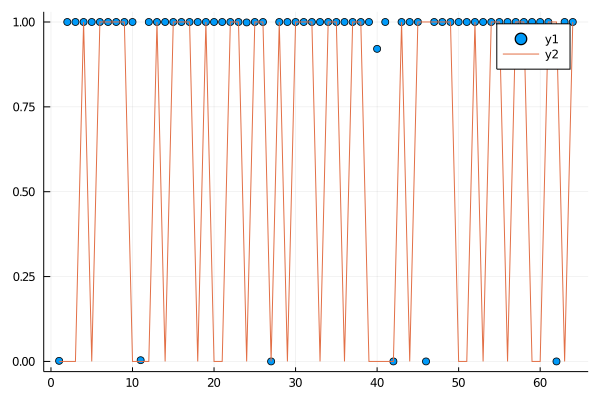

In [9]:
np=min(ntest,64)
scatter(pred(w,b,xtst)[1:np]
#    ,xlim=(0,np)
)
plot!(ytst[1:np])

In [10]:
# accuracy
function acc(w,b,x,y)
    cnt = 0
    tot = length(x[1,:])
    for i=1:tot-1
        chk = (pred(w,b,x[:,i])[1] - y[i][1])^2
        if (chk < 0.5)
            cnt += 1
        end
    end
    return 1.0*cnt/tot
end

acc (generic function with 1 method)

In [11]:
acc(w,b,xtrn,ytrn),acc(w,b,xtst,ytst)

(0.5099078984091543, 0.486328125)

In [12]:
sumtrn = 0.0; sumtst = 0.0

for i=1:100
    trainidx, testidx = mlp.gen_data(n, ntest)
    xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)
    sumtrn += acc(w, b, xtrn,ytrn); sumtst += acc(w, b, xtst,ytst)
end

(sumtrn/100,sumtst/100) # (overfitted but works)

(0.506918783142618, 0.5080078125)

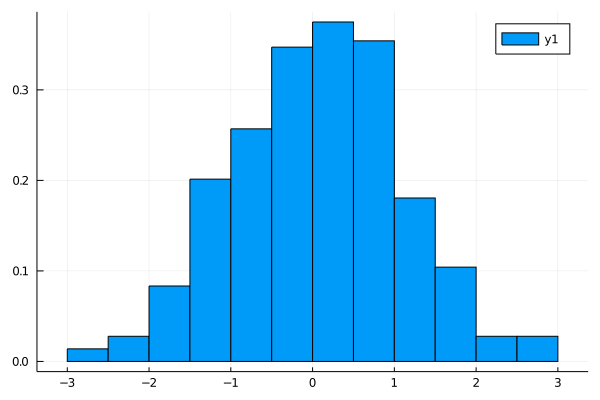

In [13]:
# distribution of weights
histogram(reshape(w1,:,1)[:,1],normalize=:pdf)

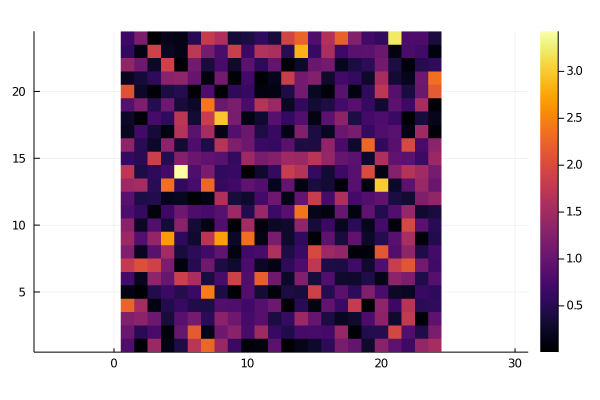

In [14]:
heatmap(abs.(value(w2)),aspect_ratio=1)

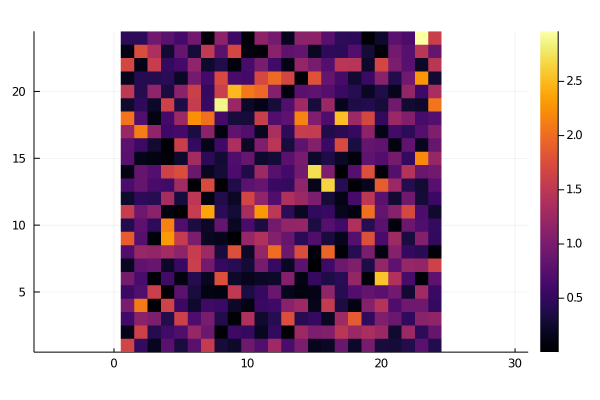

In [15]:
heatmap(abs.(value(w3)),aspect_ratio=1)

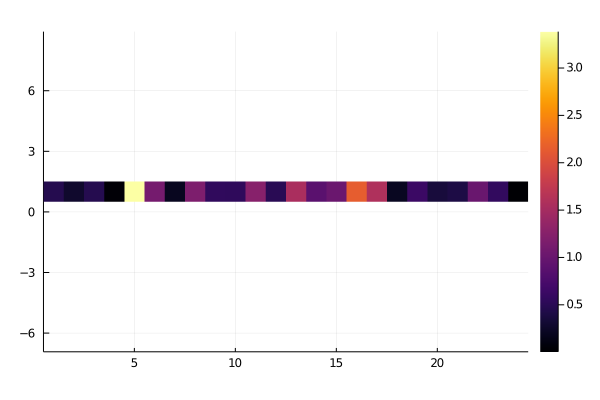

In [16]:
heatmap(abs.(value(w4)),aspect_ratio=1)

In [17]:
includet("../codebase/metrics.jl")
using .metrics
A = computeKernel(w, (xdim, h1, h2, h3, ydim))
metrics.net_density(A)

0.10259103641456582